In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.cluster import KMeans
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode(connected=True)
from sklearn.metrics.cluster import homogeneity_score
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups
import re
np.random.seed(0)

# Dataset 

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics. Each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian).

In [68]:
categories = [
    'comp.sys.ibm.pc.hardware',
    'talk.religion.misc',
    'rec.sport.baseball',
    'sci.space',
]

data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42,categories=categories)

In [69]:
map_tags = {}
map_tags[0] = "hardware"
map_tags[1] = "baseball"
map_tags[2] = "space"
map_tags[3] = "religion"

In [44]:
data_class = data.target
data_text  = data.data

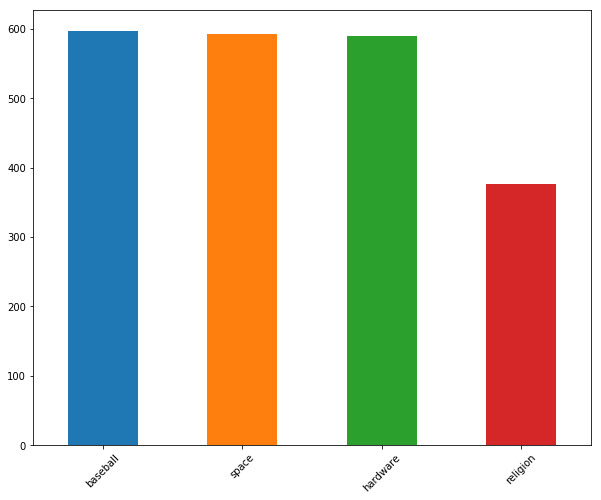

In [45]:
d = {'text':data_text,'class':data_class}
df_data_all = pd.DataFrame(d)

df_data_all["class"] = df_data_all["class"].apply( lambda x: map_tags[int(x)])

df_data_all["class"].value_counts().plot.bar( figsize = (10, 8), rot=45 )

In [46]:
def to_clean_text(text):
    
    text = re.sub("\d+","",text)
    text = re.sub("\n+"," ",text)
    text = re.sub(" +"," ",text)
    text = text.lower()
    
    return text 



In [47]:
data_text = [to_clean_text(text) for text in data_text]

data_class = df_data_all["class"].values

In [48]:
count_vect = CountVectorizer(stop_words="english")
text_vectors = count_vect.fit_transform(data_text)
X_transform = TSNE(n_components=3).fit_transform(text_vectors.toarray())

In [49]:
text_vectors.shape

(2157, 28163)

# Original data

In [50]:
d = {'x':X_transform[:,0],'y':X_transform[:,1], 'z': X_transform[:,2],'Score':data_class}
df = pd.DataFrame(d)

In [51]:
fig = px.scatter_3d(df, x="x", y="y", z="z",color="Score")
fig.show()

# KMeans

In [52]:
est = KMeans(n_clusters=4)
est.fit(text_vectors)
labels = est.labels_

In [53]:
labels_cat = [ map_tags[lab] for lab in labels ]

In [54]:
d = {'x':X_transform[:,0],'y':X_transform[:,1], 'z': X_transform[:,2],'Score':labels_cat}
df = pd.DataFrame(d)

In [55]:
homogeneity_score(data_class,labels)

0.007981010430102268

In [56]:
fig = px.scatter_3d(df, x="x", y="y", z="z",color="Score")
fig.show()

# Non-negative matrix factorization 

In [57]:
text_vectors_T = text_vectors.T

In [58]:
text_vectors_T.shape

(28163, 2157)

In [59]:
model = NMF(n_components=4, init='random', random_state=0,beta_loss="kullback-leibler",solver="mu")
W = model.fit_transform(text_vectors_T)
H = model.components_

/usr/local/lib/python3.7/site-packages/sklearn/decomposition/nmf.py:1069: ConvergenceWarning:

Maximum number of iteration 200 reached. Increase it to improve convergence.



In [60]:
W.shape

(28163, 4)

In [61]:
H.shape

(4, 2157)

In [62]:
l,c = H.shape
l,c

(4, 2157)

In [63]:
labels_NMF = []
for index in range(c):

    col = H[:,index]
    
    cluster = np.argmax(col)
    
    labels_NMF.append(cluster)
    

In [70]:
labels_NMF_cat = [ map_tags[lab] for lab in labels_NMF ]

In [71]:
d = {'x':X_transform[:,0],'y':X_transform[:,1], 'z': X_transform[:,2],'Score':labels_NMF_cat}
df = pd.DataFrame(d)

In [72]:
homogeneity_score(data_class,labels_NMF)

0.6425580335833947

In [73]:
fig = px.scatter_3d(df, x="x", y="y", z="z",color="Score")
fig.show()

In [ ]:
from sklearn import preprocessing
X_norm = preprocessing.normalize(text_vectors_T, norm='l2',axis=1)

In [ ]:
def NMF(X, p, e, repetitions):
    n = X.shape[0]
    m = X.shape[1]
    U = np.random.rand(n, p)
    V = np.random.rand(p, m)
    err = 1000
    alpha = 0.02
    delta = 0.00001
    c = 0
    while(err > e and c<repetitions):
        # Update U
        XV_T = X @ V.T
        UVV_T =  (U @ V @ V.T) + delta

        #W = W * AH_T / WHH_T
        for i in range(np.size(U, 0)):
            for j in range(np.size(U, 1)):
                U[i, j] = U[i, j] * XV_T[i, j] / UVV_T[i, j]
               
        # Update V
        X_TU = X.T @ U
        V_TU_TU = (V.T @ U.T @ U) + delta
        #H = H * W_TA / W_TWH
       
        for i in range(np.size(V, 1)):
            for j in range(np.size(V, 0)):
                try:
                    V.T[i, j] = V.T[i, j] * X_TU[i, j] / V_TU_TU[i, j]
                except:
                    print(V.shape, X_TU.shape, V_TU_TU.shape, i, j)
       
       
        #err = mean_square_error(X, U@V)
        if c % 10 == 0:
            print('Iter ',c)
        c += 1
   
#         for j in range(U.shape[1]):    
#             U[:,j] = U[:,j]/np.sqrt(np.sum(U[:,j]**2))#preprocessing.normalize(U, axis=1)  
#         for j in range(V.T.shape[1]):    
#             V.T[:,j] = V.T[:,j]/np.sqrt(np.sum(U[:,j]**2))
   
    return U, V

In [ ]:
W_, H_ = NMF(text_vectors_T, p=4, e=00000000.1, repetitions=2000)

In [ ]:
labels_NMF_ = []
for index in range(H_.shape[1]):

    col = H_[:,index]
    
    cluster = np.argmax(col)
    
    labels_NMF_.append(cluster)


In [ ]:
homogeneity_score(data_class,labels_NMF_)